# Test de nouvelles features

Ce notebook a pour but de tester de nouvelles features pour le modèle de prédiction

## Preprocessing...

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [2]:
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': 0,
        'GapToLeader': 0,
        'IntervalToPositionAhead': 0,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

In [3]:
def preprocess(df):
    print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    print('Datatypes processed...', df.shape)
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    return df

In [170]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    year_csv['Year'] = year
    data = pd.concat([
        data,
        year_csv
    ])

df = preprocess(data.copy())

Preprocessing data... (87845, 28)
TrackStatus processed... (87845, 33)
Missing values processed... (84630, 33)
Datatypes processed... (84630, 33)
Target processed... (84630, 34)
Features removed... (84630, 24)


## Functions

In [32]:
from matplotlib.gridspec import GridSpec

def plot_feature_improvement(df, old_feature, new_feature):
    pitting_df = df[df['is_pitting'] == True]
    not_pitting_df = df[df['is_pitting'] == False]

    fig = plt.figure(figsize=(15, 5), constrained_layout=True)

    gs = GridSpec(3, 7, figure=fig)
    ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3, rowspan=3))
    ax2 = plt.subplot(gs.new_subplotspec((0, 3), colspan=3, rowspan=3))
    ax3 = plt.subplot(gs.new_subplotspec((0, 6), colspan=1, rowspan=1))
    ax4 = plt.subplot(gs.new_subplotspec((1, 6), colspan=1, rowspan=1))
    ax5 = plt.subplot(gs.new_subplotspec((2, 6), colspan=1, rowspan=1))

    sns.kdeplot(pitting_df[new_feature], label='Pitting', ax=ax1)
    sns.kdeplot(not_pitting_df[new_feature], label='Not pitting', ax=ax1)
    ax1.grid()
    ax1.legend()
    ax1.set_title('Distribution of ' + new_feature)
    ax1.sharey(ax2)
    
    sns.kdeplot(pitting_df[old_feature], label='Pitting', ax=ax2)
    sns.kdeplot(not_pitting_df[old_feature], label='Not pitting', ax=ax2)
    ax2.grid()
    ax2.legend()
    ax2.set_title('Distribution of ' + old_feature)

    corr1 = df[[old_feature, new_feature, 'is_pitting']].corr('pearson')[['is_pitting']].sort_values(by='is_pitting', ascending=False)
    corr2 = df[[old_feature, new_feature, 'is_pitting']].corr('spearman')[['is_pitting']].sort_values(by='is_pitting', ascending=False)
    corr3 = df[[old_feature, new_feature, 'is_pitting']].corr('kendall')[['is_pitting']].sort_values(by='is_pitting', ascending=False)

    sns.heatmap(corr1.drop('is_pitting'), annot=True, fmt='.2f', cmap='coolwarm', ax=ax3, cbar=False)
    ax3.set_title('Pearson')

    sns.heatmap(corr2.drop('is_pitting'), annot=True, fmt='.2f', cmap='coolwarm', ax=ax4, cbar=False)
    ax4.set_title('Spearman')

    sns.heatmap(corr3.drop('is_pitting'), annot=True, fmt='.2f', cmap='coolwarm', ax=ax5, cbar=False)
    ax5.set_title('Kendall')

    plt.show()


from sklearn.preprocessing import StandardScaler

def scale_features(df, new_feature, old_feature):
    scaler = StandardScaler()
    scaler.fit(df[[old_feature, new_feature]])
    df[[old_feature, new_feature]] = scaler.transform(df[[old_feature, new_feature]])
    return df


## Hypothèses

1. Normaliser le temps au tour par rapport au temps au tour median du même circuit permet de mieux comparer les temps au tour entre les circuits et donc d'avoir une meilleure prédiction des arrêt au stand

In [70]:
df_hyp = df.copy()
df_hyp['LapTimeProportional'] = df_hyp['LapTime'] / df_hyp.groupby('Track')['LapTime'].transform('median')

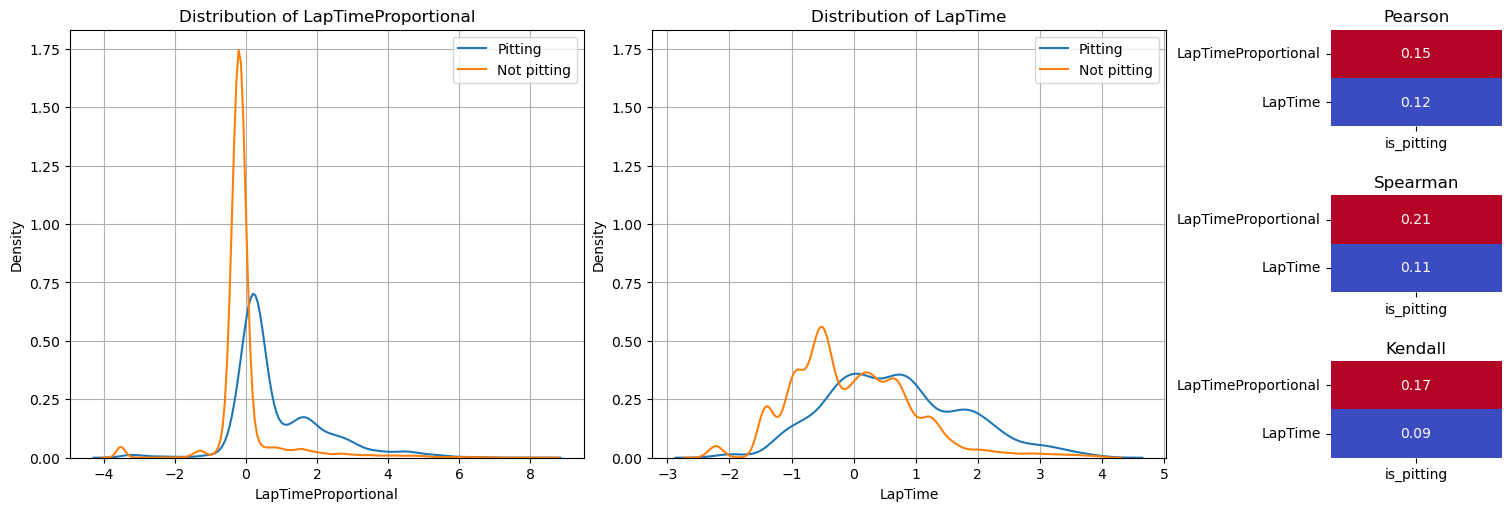

In [71]:
scale_features(df_hyp, 'LapTimeProportional', 'LapTime')
plot_feature_improvement(df_hyp, 'LapTime', 'LapTimeProportional')


2. Normaliser le nombre de tours effectués par le nombre de tour total du cicruit permet de mieux comparer les circuits entre eux.

In [72]:
df_hyp = df.copy()
df_hyp['RacePercentage'] = df_hyp['LapNumber'] / df_hyp['TotalLaps']

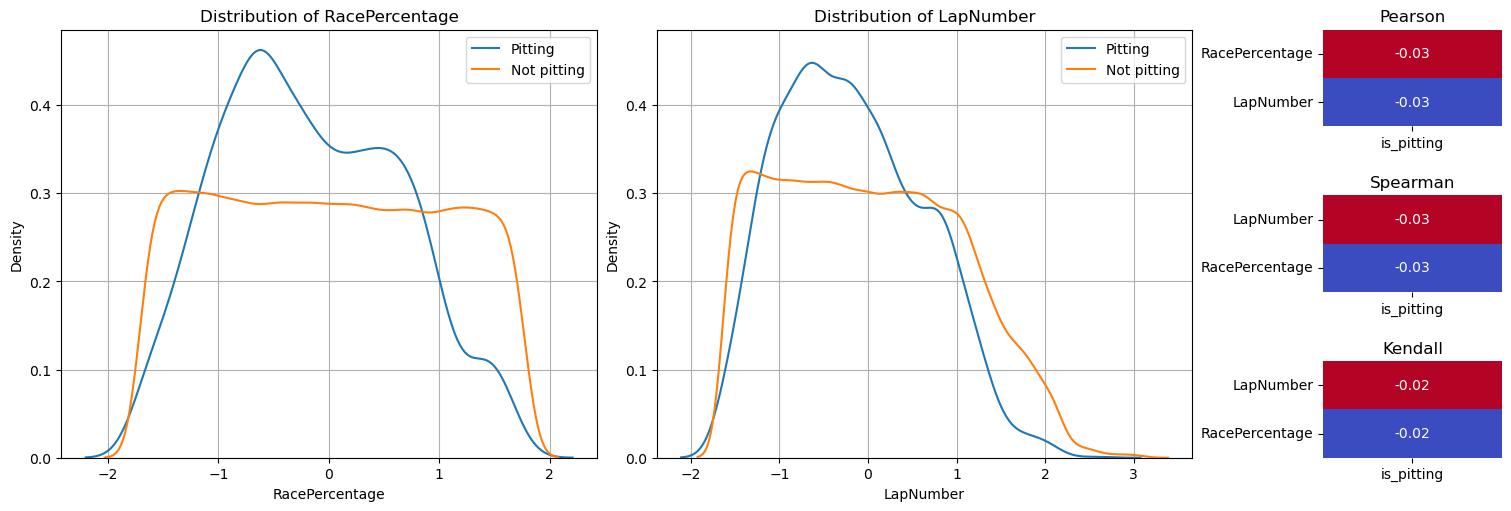

In [73]:
scale_features(df_hyp, 'RacePercentage', 'LapNumber')
plot_feature_improvement(df_hyp, 'LapNumber', 'RacePercentage')

3. Mesurer le nombre d'arrêt au tour moyen permet d'avoir une meilleure idée du nombre d'arrêt au stand à effectuer et donc d'avoir une meilleure prédiction des arrêt au stand

In [110]:
df_hyp = df.copy()
average_nb_pit_per_track = df_hyp.query('LapNumber == TotalLaps').groupby('Track')['NumberOfPitStops'].mean()
df_hyp['DeltaAvgNbPitStop'] =  df_hyp['NumberOfPitStops'] - df_hyp['Track'].map(average_nb_pit_per_track).astype('float32')

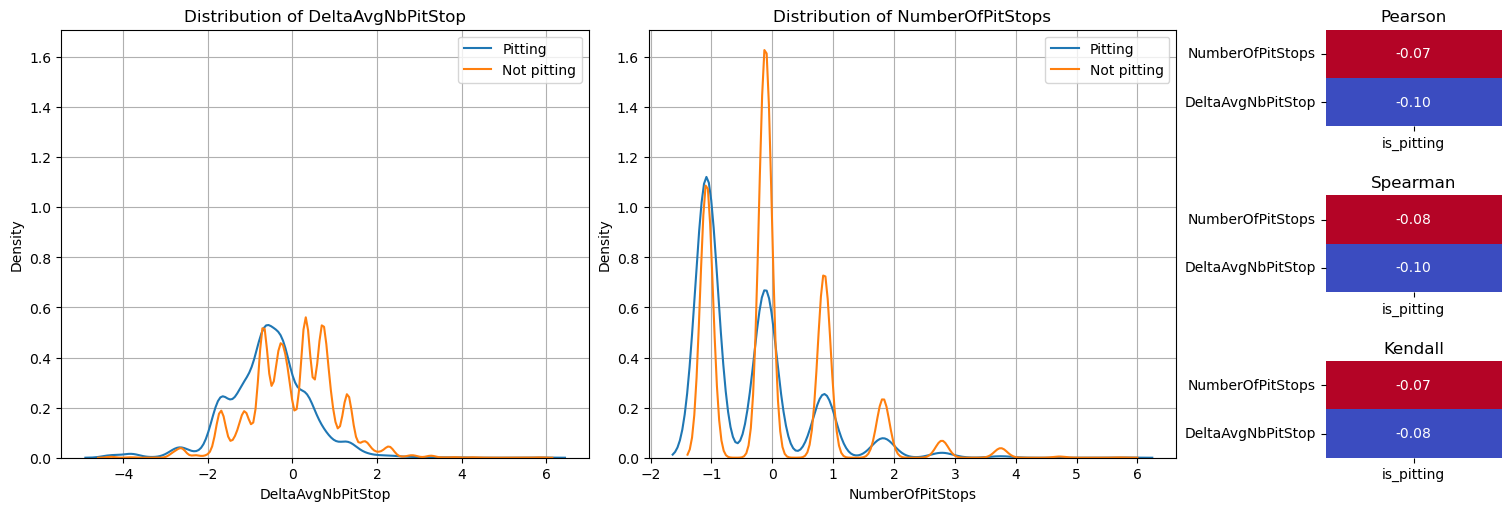

In [111]:
scale_features(df_hyp, 'DeltaAvgNbPitStop', 'NumberOfPitStops')
plot_feature_improvement(df_hyp, 'NumberOfPitStops', 'DeltaAvgNbPitStop')

4. Créer une feature qui indique la différence entre le temps au tour et le temps au tour moyen du même composé de pneu sur le même circuit

In [133]:
df_hyp = df.copy()
df_hyp['LapTimeXLapNumber'] = df_hyp['LapTime'] * df_hyp['LapNumber'] # TODO : find a better way to account for the fuel load
laptime_lapnb_corrected_per_track_per_compound = df_hyp.groupby(['Track', 'Compound'])['LapTimeXLapNumber'].median()
df_hyp = df_hyp.join(laptime_lapnb_corrected_per_track_per_compound, on=['Track', 'Compound'], rsuffix='_corrected')

p:\Anaconda\envs\bsc\lib\site-packages\seaborn\utils.py:80: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


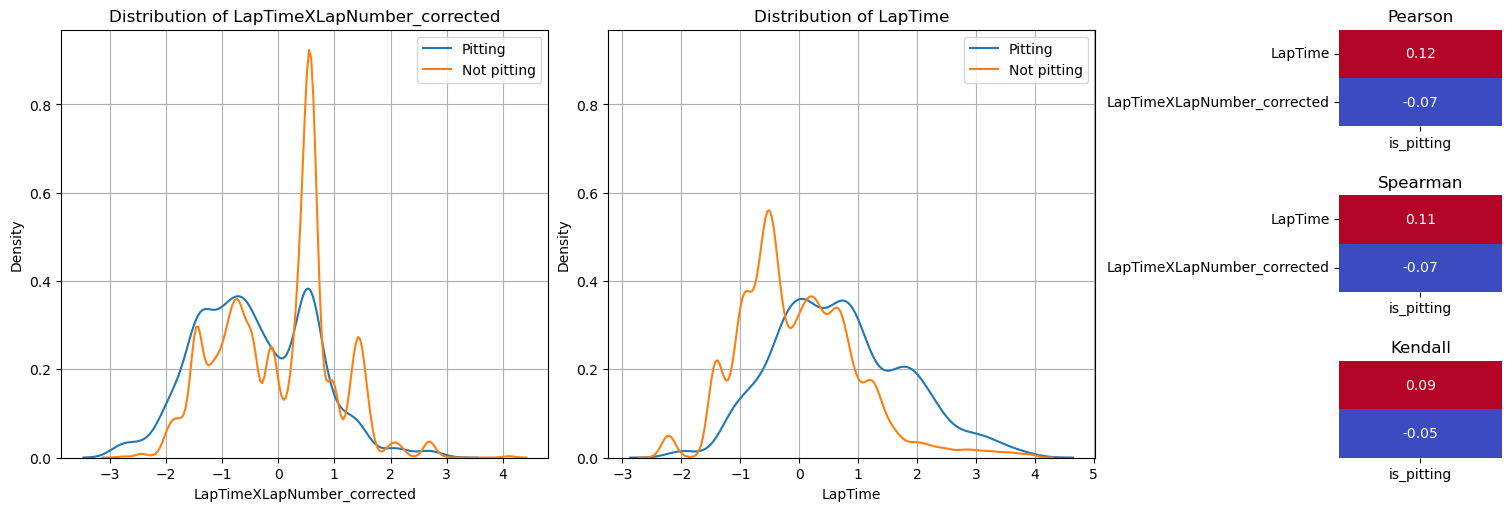

In [134]:
scale_features(df_hyp, 'LapTime', 'LapTimeXLapNumber_corrected')
plot_feature_improvement(df_hyp, 'LapTime', 'LapTimeXLapNumber_corrected')

5. Créer une feature qui indique la différence entre le temps au tour et le temps le plus rapide du relai en cours

In [189]:
df2 = df.copy()

In [190]:
minimum_lap_time_per_stint = df2.groupby(['Year', 'Track', 'DriverNumber', 'Stint'])['LapTime'].min()

In [191]:
df2['MinStint'] = df2[['Year', 'Track', 'DriverNumber', 'Stint']].apply(lambda x: minimum_lap_time_per_stint.loc[x['Year'], x['Track'], x['DriverNumber'], x['Stint']], axis=1)

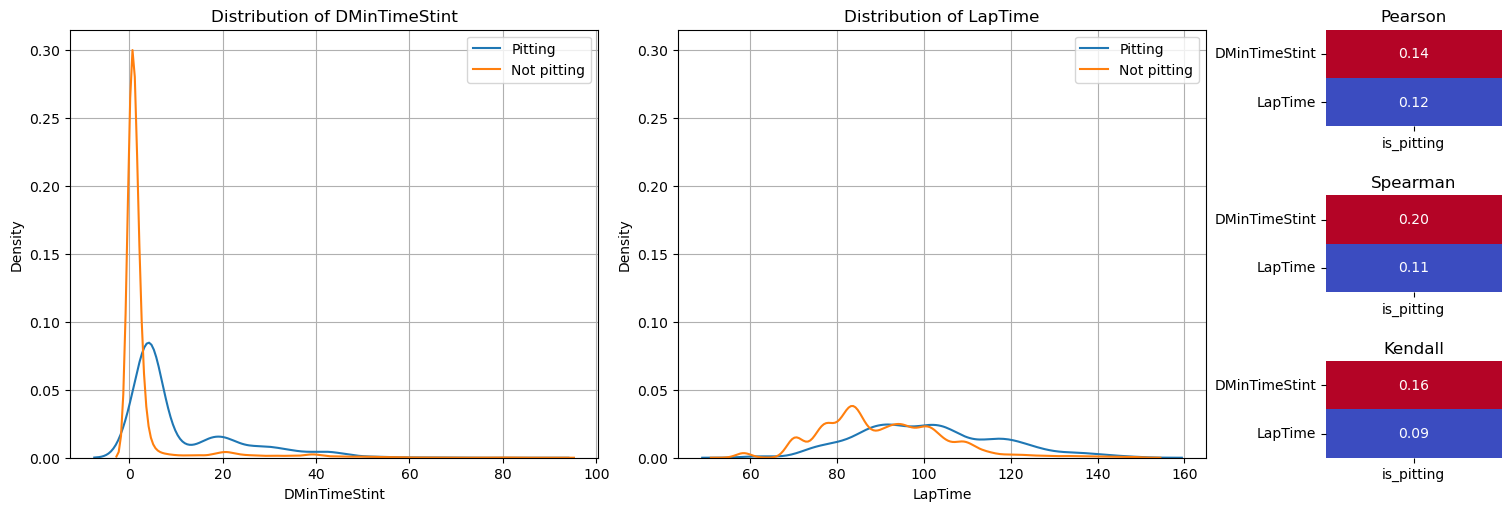

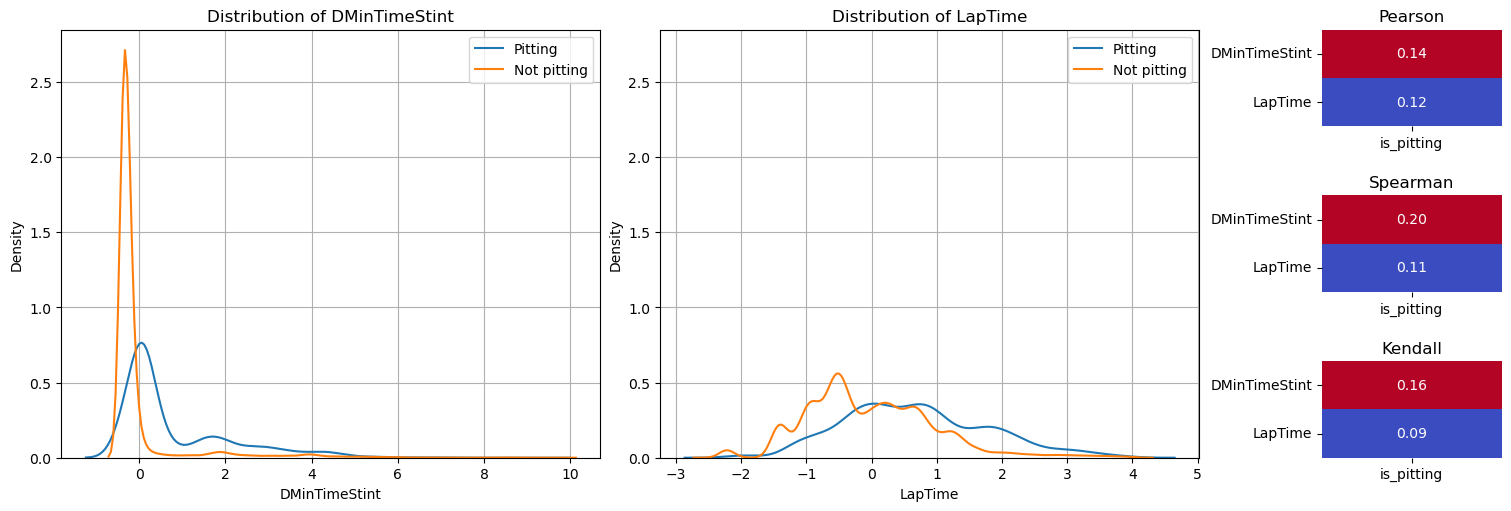

In [192]:
df2['DMinTimeStint'] = df2['LapTime'] - df2['MinStint']

plot_feature_improvement(df2, 'LapTime', 'DMinTimeStint')
scale_features(df2, 'DMinTimeStint', 'LapTime')
plot_feature_improvement(df2, 'LapTime', 'DMinTimeStint')

In [228]:
df2 = df.copy()
monza = df2.query('Track == "Silverstone" and Green == True')

In [238]:
monza_time_series = pd.DataFrame()
monza_time_series['LapTime'] = monza.groupby('LapNumber')['LapTime'].median()
monza_time_series['LapTime'] = monza_time_series['LapTime'].interpolate(method='linear')
monza_time_series['NumberOfPitStops'] = monza.groupby('LapNumber')['is_pitting'].sum()
monza_time_series['Soft'] = monza.groupby('LapNumber')['Compound'].apply(lambda x: (x == 'SOFT').sum())
monza_time_series['Medium'] = monza.groupby('LapNumber')['Compound'].apply(lambda x: (x == 'MEDIUM').sum())
monza_time_series['Hard'] = monza.groupby('LapNumber')['Compound'].apply(lambda x: (x == 'HARD').sum())

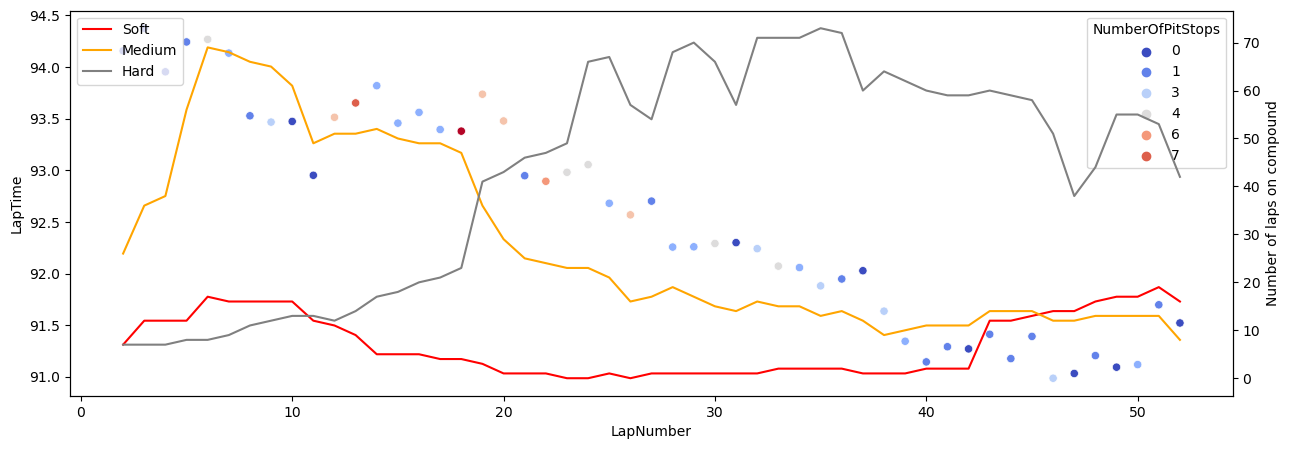

In [242]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.scatterplot(data=monza_time_series, x='LapNumber', y='LapTime', hue='NumberOfPitStops', palette='coolwarm', ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=monza_time_series, x='LapNumber', y='Soft', ax=ax2, color='red', label='Soft')
sns.lineplot(data=monza_time_series, x='LapNumber', y='Medium', ax=ax2, color='orange', label='Medium')
sns.lineplot(data=monza_time_series, x='LapNumber', y='Hard', ax=ax2, color='grey', label='Hard')

ax2.set_ylabel('Number of laps on compound')
ax2.legend(loc='upper left')


In [239]:
monza_time_series.head()

,LapTime,NumberOfPitStops,Soft,Medium,Hard
LapNumber,,,,,
2,94.156998,0,7,26,7
3,94.375999,0,12,36,7
4,93.954002,0,12,38,7
5,94.242996,1,12,56,8
6,94.267998,4,17,69,8
